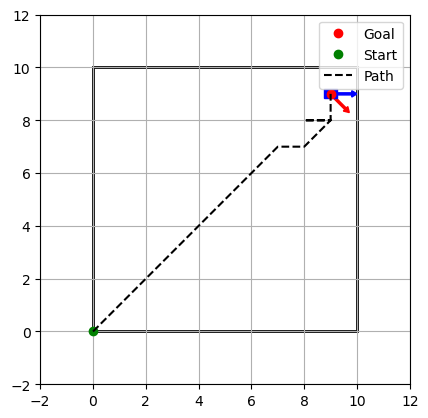

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
from matplotlib.patches import Rectangle, Arrow
from IPython.display import display, clear_output
import gym

class DiscreteUnicycleEnv(gym.Env):
    def __init__(self, grid_size=10):
        super(DiscreteUnicycleEnv, self).__init__()
        self.grid_size = grid_size
        self.max_x = grid_size
        self.max_y = grid_size

        self.action_space = gym.spaces.Discrete(8)  # 8 possible directions
        self.observation_space = gym.spaces.Box(low=0, high=grid_size, shape=(3,), dtype=np.int32)
        
        self.initial_state = np.array([0, 0, 0], dtype=np.int32)  # حالت اولیه ثابت
        self.goal = np.array([grid_size - 1, grid_size - 1, 7])  # نقطه هدف ثابت
        
        self.state = self.initial_state.copy()
        self.relative_state = self.get_relative_state()
        
        self.path = []
        self.fig, self.ax = plt.subplots()
        self.max_steps_per_episode = 50  # کاهش تعداد گام‌ها در هر اپیزود

    def reset(self):
        self.state = self.initial_state.copy()  # حالت اولیه ثابت
        self.relative_state = self.get_relative_state()
        self.path = [self.state[:2].copy()]
        return self.state

    def step(self, action):
        x, y, theta = self.state
        if action == 0:  # right
            x += 1
        elif action == 1:  # up-right
            x += 1
            y += 1
        elif action == 2:  # up
            y += 1
        elif action == 3:  # up-left
            x -= 1
            y += 1
        elif action == 4:  # left
            x -= 1
        elif action == 5:  # down-left
            x -= 1
            y -= 1
        elif action == 6:  # down
            y -= 1
        elif action == 7:  # down-right
            x += 1
            y -= 1

        x = np.clip(x, 0, self.grid_size - 1)
        y = np.clip(y, 0, self.grid_size - 1)
        self.state = np.array([x, y, theta])

        self.relative_state = self.get_relative_state()
        self.path.append(self.state[:2].copy())

        done = np.array_equal(self.state[:2], self.goal[:2])
        reward = -np.linalg.norm(self.state[:2] - self.goal[:2])
        if done:
            reward += 100

        return self.state, reward, done, {}

    def get_relative_state(self):
        x, y, theta = self.state
        goal_x, goal_y, goal_theta = self.goal
        dx = goal_x - x
        dy = goal_y - y
        ex = (np.cos(theta * np.pi / 4) * dx + np.sin(theta * np.pi / 4) * dy) * 2
        ey = (-np.sin(theta * np.pi / 4) * dx + np.cos(theta * np.pi / 4) * dy) * 2
        ex = np.rint(ex)
        ey = np.rint(ey)
        etheta = (goal_theta - theta) % 8
        return np.array([ex, ey, etheta], dtype=np.int16)

    def render(self, mode='human'):
        x, y, theta = self.state
        goal_x, goal_y, goal_theta = self.goal
        self.ax.clear()
        buffer = 2
        self.ax.set_xlim(-buffer, self.max_x + buffer)
        self.ax.set_ylim(-buffer, self.max_y + buffer)
        self.ax.add_patch(Rectangle((0, 0), self.max_x, self.max_y, fill=None, edgecolor='k', linestyle='-', linewidth=2))
        self.ax.plot(goal_x, goal_y, 'ro', label='Goal')
        self.ax.add_patch(Arrow(goal_x, goal_y, np.cos(goal_theta * np.pi / 4), np.sin(goal_theta * np.pi / 4), width=0.4, color='r'))
        self.ax.plot(self.path[0][0], self.path[0][1], 'go', label='Start')
        path = np.array(self.path)
        self.ax.plot(path[:, 0], path[:, 1], 'k--', label='Path')
        width, height = self.max_x / 20, self.max_x / 30
        robot = Rectangle((x - 0.5 * width, y - 0.5 * height), width, height, angle=np.degrees(theta * np.pi / 4), edgecolor='b', facecolor='b')
        self.ax.add_patch(robot)
        self.ax.add_patch(Arrow(x, y, np.cos(theta * np.pi / 4), np.sin(theta * np.pi / 4), width=0.4, color='b'))
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.legend()
        self.ax.grid(True)
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.001)

    def close(self):
        plt.close(self.fig)

env = DiscreteUnicycleEnv()

class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros(state_size + (action_size,))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state[0], state[1], state[2]])

    def learn(self, state, action, reward, next_state, done):
        q_update = reward
        if not done:
            q_update += self.discount_factor * np.max(self.q_table[next_state[0], next_state[1], next_state[2]])
        self.q_table[state[0], state[1], state[2], action] += self.learning_rate * (q_update - self.q_table[state[0], state[1], state[2], action])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

state_size = (env.grid_size, env.grid_size, 8)
action_size = env.action_space.n
agent = QLearningAgent(state_size, action_size)

episodes = 500
max_steps = 50

average_rewards = []

for e in tqdm(range(episodes), desc="Training Episodes"):
    state = env.reset()
    total_reward = 0
    for _ in range(max_steps):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    average_rewards.append(total_reward / max_steps)

# ذخیره میانگین پاداش‌ها در فایل
np.save('average_rewards.npy', average_rewards)

# رسم نمودار میانگین پاداش‌ها
plt.plot(average_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Q-learning Average Rewards per Episode')
plt.savefig('plot.png')
plt.show()

# پس از آموزش مدل، محیط را برای نمایش گرافیکی اجرا کنید
state = env.reset()
done = False
while not done:
    action = agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    env.render()
    state = next_state
env.close()


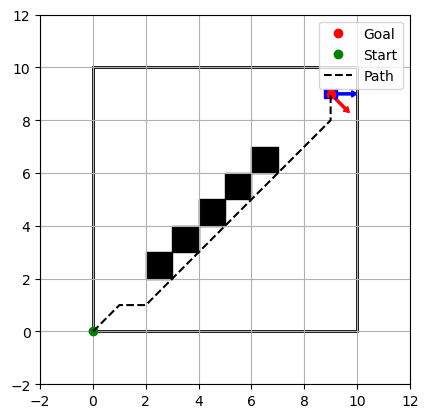

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
from matplotlib.patches import Rectangle, Arrow
from IPython.display import display, clear_output
import gym

class DiscreteUnicycleEnv(gym.Env):
    def __init__(self, grid_size=10, obstacles=None):
        super(DiscreteUnicycleEnv, self).__init__()
        self.grid_size = grid_size
        self.max_x = grid_size
        self.max_y = grid_size

        self.action_space = gym.spaces.Discrete(8)  # 8 possible directions
        self.observation_space = gym.spaces.Dict({
            'state': gym.spaces.Box(low=0, high=grid_size, shape=(3,), dtype=np.int32),
            'obstacles': gym.spaces.Box(low=0, high=1, shape=(grid_size, grid_size), dtype=np.int32)
        })

        self.initial_state = np.array([0, 0, 0], dtype=np.int32)  # حالت اولیه ثابت
        self.goal = np.array([grid_size - 1, grid_size - 1, 7])  # نقطه هدف ثابت
        
        self.state = self.initial_state.copy()
        self.relative_state = self.get_relative_state()

        self.obstacles = np.zeros((grid_size, grid_size), dtype=np.int32)
        if obstacles:
            for obs in obstacles:
                self.obstacles[obs] = 1
        
        self.path = []
        self.fig, self.ax = plt.subplots()
        self.max_steps_per_episode = 50  # کاهش تعداد گام‌ها در هر اپیزود

    def reset(self):
        self.state = self.initial_state.copy()  # حالت اولیه ثابت
        self.relative_state = self.get_relative_state()
        self.path = [self.state[:2].copy()]
        return {'state': self.state, 'obstacles': self.obstacles}

    def step(self, action):
        x, y, theta = self.state
        if action == 0:  # right
            x += 1
        elif action == 1:  # up-right
            x += 1
            y += 1
        elif action == 2:  # up
            y += 1
        elif action == 3:  # up-left
            x -= 1
            y += 1
        elif action == 4:  # left
            x -= 1
        elif action == 5:  # down-left
            x -= 1
            y -= 1
        elif action == 6:  # down
            y -= 1
        elif action == 7:  # down-right
            x += 1
            y -= 1

        x = np.clip(x, 0, self.grid_size - 1)
        y = np.clip(y, 0, self.grid_size - 1)
        self.state = np.array([x, y, theta])

        self.relative_state = self.get_relative_state()
        self.path.append(self.state[:2].copy())

        done = self.is_done()
        reward = self.get_reward()

        return {'state': self.state, 'obstacles': self.obstacles}, reward, done, {}

    def get_relative_state(self):
        x, y, theta = self.state
        goal_x, goal_y, goal_theta = self.goal
        dx = goal_x - x
        dy = goal_y - y
        ex = (np.cos(theta * np.pi / 4) * dx + np.sin(theta * np.pi / 4) * dy) * 2
        ey = (-np.sin(theta * np.pi / 4) * dx + np.cos(theta * np.pi / 4) * dy) * 2
        ex = np.rint(ex)
        ey = np.rint(ey)
        etheta = (goal_theta - theta) % 8
        return np.array([ex, ey, etheta], dtype=np.int16)

    def get_reward(self):
        x, y, theta = self.state
        if self.obstacles[x, y] == 1:  # برخورد با مانع
            return -100
        distance = np.sqrt((x - self.goal[0])**2 + (y - self.goal[1])**2)
        reward = -distance
        if self.is_done():
            reward += 100
        else:
            reward -= 1  # جریمه برای هر قدم
        return reward

    def is_done(self):
        x, y, theta = self.state
        if self.obstacles[x, y] == 1:  # برخورد با مانع
            return True
        return np.array_equal(self.state[:2], self.goal[:2])

    def render(self, mode='human'):
        x, y, theta = self.state
        goal_x, goal_y, goal_theta = self.goal
        self.ax.clear()
        buffer = 2
        self.ax.set_xlim(-buffer, self.max_x + buffer)
        self.ax.set_ylim(-buffer, self.max_y + buffer)
        self.ax.add_patch(Rectangle((0, 0), self.max_x, self.max_y, fill=None, edgecolor='k', linestyle='-', linewidth=2))
        self.ax.plot(goal_x, goal_y, 'ro', label='Goal')
        self.ax.add_patch(Arrow(goal_x, goal_y, np.cos(goal_theta * np.pi / 4), np.sin(goal_theta * np.pi / 4), width=0.4, color='r'))
        self.ax.plot(self.path[0][0], self.path[0][1], 'go', label='Start')

        # Plot obstacles
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.obstacles[i, j] == 1:
                    self.ax.add_patch(Rectangle((i, j), 1, 1, color='black'))

        path = np.array(self.path)
        self.ax.plot(path[:, 0], path[:, 1], 'k--', label='Path')
        width, height = self.max_x / 20, self.max_x / 30
        robot = Rectangle((x - 0.5 * width, y - 0.5 * height), width, height, angle=np.degrees(theta * np.pi / 4), edgecolor='b', facecolor='b')
        self.ax.add_patch(robot)
        self.ax.add_patch(Arrow(x, y, np.cos(theta * np.pi / 4), np.sin(theta * np.pi / 4), width=0.4, color='b'))
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.legend()
        self.ax.grid(True)
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.001)

    def close(self):
        plt.close(self.fig)

# تعریف موانع
obstacles = [(2, 2), (3, 3), (4, 4), (5, 5), (6, 6)]

env = DiscreteUnicycleEnv(obstacles=obstacles)

class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros(state_size + (action_size,))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state['state'][0], state['state'][1], state['state'][2]])

    def learn(self, state, action, reward, next_state, done):
        q_update = reward
        if not done:
            q_update += self.discount_factor * np.max(self.q_table[next_state['state'][0], next_state['state'][1], next_state['state'][2]])
        self.q_table[state['state'][0], state['state'][1], state['state'][2], action] += self.learning_rate * (q_update - self.q_table[state['state'][0], state['state'][1], state['state'][2], action])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

state_size = (env.grid_size, env.grid_size, 8)
action_size = env.action_space.n
agent = QLearningAgent(state_size, action_size)

episodes = 500
max_steps = 50

average_rewards = []

for e in tqdm(range(episodes), desc="Training Episodes"):
    state = env.reset()
    total_reward = 0
    for _ in range(max_steps):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    average_rewards.append(total_reward / max_steps)

# ذخیره میانگین پاداش```python
# ذخیره میانگین پاداش‌ها در فایل
np.save('average_rewards.npy', average_rewards)

# رسم نمودار میانگین پاداش‌ها
plt.plot(average_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Q-learning Average Rewards per Episode')
plt.show()

# پس از آموزش مدل، محیط را برای نمایش گرافیکی اجرا کنید
state = env.reset()
done = False
while not done:
    action = agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    env.render()
    state = next_state
env.close()


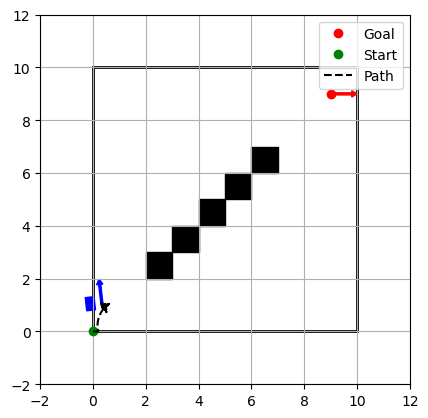

KeyboardInterrupt: 

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
from matplotlib.patches import Rectangle, Arrow
from IPython.display import display, clear_output
import gym

class ContinuousUnicycleEnv(gym.Env):
    def __init__(self, grid_size=10, obstacles=None):
        super(ContinuousUnicycleEnv, self).__init__()
        self.grid_size = grid_size
        self.max_x = grid_size
        self.max_y = grid_size

        self.action_space = gym.spaces.Discrete(9)  # 9 possible discrete actions
        self.observation_space = gym.spaces.Box(low=np.array([0.0, 0.0, 0.0]), high=np.array([grid_size, grid_size, 2*np.pi]), dtype=np.float32)

        self.initial_state = np.array([0.0, 0.0, 0.0], dtype=np.float32)  # حالت اولیه ثابت
        self.goal = np.array([grid_size - 1, grid_size - 1, 0.0], dtype=np.float32)  # نقطه هدف ثابت

        self.state = self.initial_state.copy()

        self.obstacles = np.zeros((grid_size, grid_size), dtype=np.float32)
        if obstacles:
            for obs in obstacles:
                self.obstacles[obs] = 1.0

        self.path = []
        self.fig, self.ax = plt.subplots()
        self.max_steps_per_episode = 50  # کاهش تعداد گام‌ها در هر اپیزود

    def reset(self):
        self.state = self.initial_state.copy()  # حالت اولیه ثابت
        self.path = [self.state[:2].copy()]
        return self.state

    def step(self, action):
        linear_velocity, angular_velocity = self.action_to_continuous(action)
        x, y, theta = self.state

        theta += angular_velocity
        theta = np.mod(theta, 2 * np.pi)

        x += linear_velocity * np.cos(theta)
        y += linear_velocity * np.sin(theta)

        x = np.clip(x, 0, self.grid_size - 1)
        y = np.clip(y, 0, self.grid_size - 1)

        self.state = np.array([x, y, theta], dtype=np.float32)
        self.path.append(self.state[:2].copy())

        done = self.is_done()
        reward = self.get_reward()

        return self.state, reward, done, {}

    def action_to_continuous(self, action):
        actions = {
            0: (0.0, 0.0),
            1: (0.1, 0.0),
            2: (-0.1, 0.0),
            3: (0.0, 0.1),
            4: (0.0, -0.1),
            5: (0.1, 0.1),
            6: (0.1, -0.1),
            7: (-0.1, 0.1),
            8: (-0.1, -0.1)
        }
        return actions[action]

    def get_reward(self):
        x, y, theta = self.state
        if self.obstacles[int(x), int(y)] == 1:  # برخورد با مانع
            return -100
        distance = np.sqrt((x - self.goal[0])**2 + (y - self.goal[1])**2)
        reward = -distance
        if self.is_done():
            reward += 100
        else:
            reward -= 1  # جریمه برای هر قدم
        return reward

    def is_done(self):
        x, y, theta = self.state
        if self.obstacles[int(x), int(y)] == 1:  # برخورد با مانع
            return True
        distance = np.sqrt((x - self.goal[0])**2 + (y - self.goal[1])**2)
        return distance < 0.1

    def render(self, mode='human'):
        x, y, theta = self.state
        goal_x, goal_y, goal_theta = self.goal
        self.ax.clear()
        buffer = 2
        self.ax.set_xlim(-buffer, self.max_x + buffer)
        self.ax.set_ylim(-buffer, self.max_y + buffer)
        self.ax.add_patch(Rectangle((0, 0), self.max_x, self.max_y, fill=None, edgecolor='k', linestyle='-', linewidth=2))
        self.ax.plot(goal_x, goal_y, 'ro', label='Goal')
        self.ax.add_patch(Arrow(goal_x, goal_y, np.cos(goal_theta), np.sin(goal_theta), width=0.4, color='r'))
        self.ax.plot(self.path[0][0], self.path[0][1], 'go', label='Start')

        # Plot obstacles
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.obstacles[i, j] == 1:
                    self.ax.add_patch(Rectangle((i, j), 1, 1, color='black'))

        path = np.array(self.path)
        self.ax.plot(path[:, 0], path[:, 1], 'k--', label='Path')
        width, height = self.max_x / 20, self.max_x / 30
        robot = Rectangle((x - 0.5 * width, y - 0.5 * height), width, height, angle=np.degrees(theta), edgecolor='b', facecolor='b')
        self.ax.add_patch(robot)
        self.ax.add_patch(Arrow(x, y, np.cos(theta), np.sin(theta), width=0.4, color='b'))
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.legend()
        self.ax.grid(True)
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.001)

    def close(self):
        plt.close(self.fig)

# تعریف موانع
obstacles = [(2, 2), (3, 3), (4, 4), (5, 5), (6, 6)]

env = ContinuousUnicycleEnv(obstacles=obstacles)

class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros(state_size + (action_size,))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[int(state[0]), int(state[1]), int(state[2])])

    def learn(self, state, action, reward, next_state, done):
        q_update = reward
        if not done:
            q_update += self.discount_factor * np.max(self.q_table[int(next_state[0]), int(next_state[1]), int(next_state[2])])
        self.q_table[int(state[0]), int(state[1]), int(state[2]), action] += self.learning_rate * (q_update - self.q_table[int(state[0]), int(state[1]), int(state[2]), action])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

state_size = (env.grid_size, env.grid_size, 8)
action_size = env.action_space.n
agent = QLearningAgent(state_size, action_size)

episodes = 500
max_steps = 50

average_rewards = []

for e in tqdm(range(episodes), desc="Training Episodes"):
    state = env.reset()
    total_reward = 0
    for _ in range(max_steps):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    average_rewards.append(total_reward / max_steps)

# ذخیره میانگین پاداش‌ها در فایل
np.save('average_rewards.npy', average_rewards)

# رسم نمودار میانگین پاداش‌ها
plt.plot(average_rewards)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Q-learning Average Rewards per Episode')
plt.show()

# پس از آموزش مدل، محیط را برای نمایش گرافیکی اجرا کنید
state = env.reset()
done = False
while not done:
    action = agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    env.render()
    state = next_state
env.close()
